>Curso: Curso Superior de Tecnologia em Banco de Dados: Ênfase em Data Analytics<br>
>Disciplina: Programação para Dados<br>
>Projeto: Fase 2<br>
>Aluno: Rafael de Menezes Ehlers<br>
>Data: Setembro de 2024

## Importa as bibliotecas necessárias

In [764]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Classe para carregar os dados

In [765]:
class DataLoader:
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)

    def get_data(self):
        return self.data

## Classe para pré-processamento

In [766]:
class PreProcessing:
    def __init__(self, data):
        self.data = data

    def clean_data(self):
        # Tratar valores nulos, converter tipos, etc.
        self.data['Release date'] = pd.to_datetime(self.data['Release date'], errors='coerce')
        self.data = self.data.dropna(subset=['Metacritic score'])
        return self.data

## Funções para responder às perguntas

In [767]:
class Analysis:
    def __init__(self, data):
        self.data = data

    # Pergunta 1: Jogos mais bem avaliados
    def top_metacritic_games_grouped_by_name(self, top_n=10):
        # Agrupa os jogos por nome e mantém o maior Metacritic score por nome de jogo
        grouped_games = self.data.loc[self.data.groupby('Name')['Metacritic score'].idxmax()]
        
        # Ordena os jogos por Metacritic score (decrescente) e, em caso de empate, pela data de lançamento (crescente)
        sorted_games = grouped_games.sort_values(
            by=['Metacritic score', 'Release date'],
            ascending=[False, True]
        )
        
        # Retorna os top N jogos
        return sorted_games[['Name', 'Release date', 'Metacritic score']].head(top_n)

    # Pergunta 2: Estatísticas para jogos de Role-playing
    def role_playing_stats(self):
        # Filtra os jogos do gênero "Role-playing" usando .loc
        role_playing_games = self.data.loc[self.data['Genres'].str.contains('RPG', na=False)].copy()

        # Verifica se existem jogos de role-playing
        if role_playing_games.empty:
            return {
                'DLC mean': 0,
                'DLC max': 0,
                'Positive mean': 0,
                'Positive max': 0,
                'Negative mean': 0,
                'Negative max': 0,
                'Demo materials mean': 0,
                'Demo materials max': 0
            }

        # Converte as colunas relevantes para numéricas ou conta os elementos, tratando valores ausentes
        role_playing_games['DLC count'] = pd.to_numeric(role_playing_games['DLC count'], errors='coerce').fillna(0)
        role_playing_games['Positive'] = pd.to_numeric(role_playing_games['Positive'], errors='coerce').fillna(0)
        role_playing_games['Negative'] = pd.to_numeric(role_playing_games['Negative'], errors='coerce').fillna(0)

        # Conta o número de screenshots e filmes usando str.split() e len(), e preenche NaN com 0
        role_playing_games['Screenshots'] = role_playing_games['Screenshots'].fillna('').apply(lambda x: len(x.split(',')) if x else 0)
        role_playing_games['Movies'] = role_playing_games['Movies'].fillna('').apply(lambda x: len(x.split(',')) if x else 0)

        # Calcula o número total de materiais de demonstração (Screenshots + Movies)
        role_playing_games = role_playing_games.assign(
            Demo_materials=role_playing_games['Screenshots'] + role_playing_games['Movies']
        )

        # Calcula estatísticas: média e máximo de DLCs, avaliações positivas, avaliações negativas e materiais de demonstração
        stats = {
            'DLCs médio': round(role_playing_games['DLC count'].mean(), 2),
            'DLCs máximo': round(role_playing_games['DLC count'].max(), 2),
            'Avaliações Positivas média': round(role_playing_games['Positive'].mean(), 2),
            'Avaliações Positivas  máximo': round(role_playing_games['Positive'].max(), 2),
            'Avaliações Negativas média': round(role_playing_games['Negative'].mean(), 2),
            'Avaliações Negativas máximo': round(role_playing_games['Negative'].max(), 2),
            'Materias de demonstração média': round(role_playing_games['Demo_materials'].mean(), 2),
            'Materias de demonstração máximo': round(role_playing_games['Demo_materials'].max(), 2)
        }

        return stats

    # Pergunta 3: Empresas que mais publicam jogos pagos
    # Função para encontrar os cinco publishers que mais publicam jogos pagos e calcular as estatísticas de avaliações positivas
    def top_publishers(self):
        # Filtra apenas jogos pagos
        paid_games = self.data[self.data['Price'] > 0]

        # Contabiliza o número de jogos pagos por publisher
        publisher_counts = paid_games['Publishers'].value_counts().head(5)

        # Lista para armazenar as estatísticas de cada publisher
        publisher_stats = []

        # Itera sobre os publishers mais frequentes
        for publisher in publisher_counts.index:
            # Filtra os jogos pagos do publisher
            publisher_games = paid_games[paid_games['Publishers'] == publisher]

            # Calcula a média e a mediana de avaliações positivas
            positive_mean = publisher_games['Positive'].mean()
            positive_median = publisher_games['Positive'].median()

            # Adiciona os resultados à lista
            publisher_stats.append({
                'Produtora': publisher,
                'Jogos Pagos': publisher_counts[publisher],
                'Média Rev. Pos.': round(positive_mean, 2),
                'Mediana Rev. Pos.': round(positive_median, 2)
            })

        # Cria um DataFrame a partir dos resultados
        df = pd.DataFrame(publisher_stats)

        return df

    # Pergunta 4: Crescimento de suporte para Linux
    def linux_support_growth(self):
        # Filtra os jogos que suportam Linux
        linux_support = self.data[self.data['Linux'] == True].copy()

        # Extrai o ano da data de lançamento usando .loc para evitar SettingWithCopyWarning
        linux_support.loc[:, 'Ano lançamento'] = linux_support['Release date'].dt.year

        # Filtra os jogos lançados entre 2018 e 2022
        linux_support_filtered = linux_support[(linux_support['Ano lançamento'] >= 2018) & (linux_support['Ano lançamento'] <= 2022)]

        # Conta o número de jogos por ano
        linux_games_by_year = linux_support_filtered.groupby('Ano lançamento').size()

        # Calcula o crescimento no número de jogos
        growth = linux_games_by_year.diff().fillna(0)

        # Verifica se houve crescimento geral entre 2018 e 2022
        if linux_games_by_year.iloc[-1] > linux_games_by_year.iloc[0]:
            growth_status = "Sim"
        else:
            growth_status = "Não"

        # Retorna o número de jogos por ano, o crescimento, e se houve crescimento geral
        return linux_games_by_year, growth, growth_status
    
    # Pergunta do aluno: Qual o jogo com maior nota, por categoria
    def jogo_maior_nota_por_categoria(self):
        # Filtrar jogos com Metacritic score maior que zero
        filtered_data = self.data[self.data['Metacritic score'] > 0].copy()

        # Dividir as categorias e expandir as categorias que estão separadas por vírgula
        filtered_data.loc[:, 'Categories'] = filtered_data['Categories'].str.split(',')

        # Explodir a coluna de categorias para criar uma linha para cada categoria
        exploded_data = filtered_data.explode('Categories')

        # Remover espaços em branco ao redor das categorias
        exploded_data.loc[:, 'Categories'] = exploded_data['Categories'].str.strip()

        # Para cada categoria, encontrar a maior nota
        max_scores = exploded_data.groupby('Categories')['Metacritic score'].max().reset_index()

        # Fazer o merge com os dados originais para pegar os jogos que possuem essa maior nota
        best_games = pd.merge(exploded_data, max_scores, on=['Categories', 'Metacritic score'])

        # Remover duplicatas exatas (caso um jogo tenha sido listado mais de uma vez exatamente)
        best_games_unique = best_games.drop_duplicates(subset=['Categories', 'Name'])

        # Ordenar as categorias por ordem alfabética
        result_sorted = best_games_unique[['Categories', 'Name', 'Metacritic score']].sort_values(by='Categories', ascending=True)

        # Retornar o DataFrame para possíveis usos
        return result_sorted

## Funções para criar gráficos


In [768]:
class Graphs:
    def __init__(self, data):
        self.data = data
    
    def apply_custom_style(self):
        # Definir estilo global
        plt.style.use('ggplot')  # Usar o estilo ggplot como base

        # Customizar detalhes específicos
        plt.rcParams['figure.figsize'] = (10, 6)  # Tamanho padrão dos gráficos
        plt.rcParams['axes.facecolor'] = '#f0f0f0'  # Cor de fundo dos eixos
        plt.rcParams['axes.edgecolor'] = '#333333'  # Cor da borda dos eixos
        plt.rcParams['axes.grid'] = True  # Mostrar grade
        plt.rcParams['grid.color'] = '#cccccc'  # Cor da grade
        plt.rcParams['grid.linestyle'] = '--'  # Estilo da grade
        plt.rcParams['axes.titleweight'] = 'bold'  # Título em negrito
        plt.rcParams['axes.labelweight'] = 'bold'  # Rótulos dos eixos em negrito
        plt.rcParams['font.size'] = 12  # Tamanho da fonte padrão
        plt.rcParams['legend.fontsize'] = 10  # Tamanho da fonte da legenda
        plt.rcParams['lines.linewidth'] = 2  # Largura das linhas
        plt.rcParams['lines.markersize'] = 8  # Tamanho dos marcadores
        plt.rcParams['font.family'] = 'Arial' # Fonte Arial

    # Gráfico 1: Percentual de jogos com suporte para cada sistema operacional
    def os_support_pie_chart(self):
        self.apply_custom_style()  # Aplica o estilo customizado

        # Conta os jogos que suportam cada sistema operacional
        total_games = len(self.data)
        windows_support = self.data['Windows'].sum()
        mac_support = self.data['Mac'].sum()
        linux_support = self.data['Linux'].sum()

        # Calcula a porcentagem de suporte para cada sistema
        os_support = {
            'Windows': (windows_support / total_games) * 100,
            'Mac': (mac_support / total_games) * 100,
            'Linux': (linux_support / total_games) * 100
        }

        # Gera o gráfico de pizza
        labels = list(os_support.keys())
        sizes = list(os_support.values())
        colors = ['#66c2a5', '#fc8d62', '#8da0cb']  # Definir cores personalizadas
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False, colors=colors)
        plt.title('Percentual de Jogos com Suporte para Sistemas Operacionais')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()

    # Gráfico 2: Jogos single-player Indie e Estratégia por ano
    def indie_strategy_trend(self):
        self.apply_custom_style()  # Aplica o estilo customizado

        # Filtra os jogos de gêneros Indie e Strategy que também são single-player
        indie_games = self.data[
            (self.data['Genres'].str.contains('Indie', na=False)) & 
            (self.data['Categories'].str.contains('Single-player', na=False))
        ]
        strategy_games = self.data[
            (self.data['Genres'].str.contains('Strategy', na=False)) & 
            (self.data['Categories'].str.contains('Single-player', na=False))
        ]
        
        # Agrupa por ano de lançamento, considerando o intervalo entre 2010 e 2020
        indie_by_year = indie_games[(indie_games['Release date'].dt.year >= 2010) & (indie_games['Release date'].dt.year <= 2020)].groupby(indie_games['Release date'].dt.year).size()
        strategy_by_year = strategy_games[(strategy_games['Release date'].dt.year >= 2010) & (strategy_games['Release date'].dt.year <= 2020)].groupby(strategy_games['Release date'].dt.year).size()

        # Gera o gráfico de linhas mostrando a tendência de jogos Indie e Strategy
        plt.plot(indie_by_year.index, indie_by_year.values, label='Indie', marker='o', color='blue')
        plt.plot(strategy_by_year.index, strategy_by_year.values, label='Strategy', marker='x', color='green')
        plt.title('Número de Jogos Indie e Estratégia Single-Player Lançados por Ano (2010-2020)')
        plt.xlabel('Ano')
        plt.ylabel('Número de Jogos')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Gráfico do aluno: Percentual de jogos lançados por ano.
    def jogos_lancados_por_ano_pizza(self):
        # Aplica o estilo customizado
        self.apply_custom_style()

        # Certifique-se de usar cópias do DataFrame se necessário
        self.data = self.data.copy()

        # Converte 'Release date' para datas, ignorando erros
        self.data['Release date'] = pd.to_datetime(self.data['Release date'], errors='coerce')

        # Extraindo o ano de lançamento e removendo valores nulos
        self.data['Release Year'] = self.data['Release date'].dt.year
        self.data = self.data.dropna(subset=['Release Year'])

        # Convertendo para inteiro para evitar possíveis erros de tipo
        self.data['Release Year'] = self.data['Release Year'].astype(int)

        # Cria uma nova coluna agrupando anos antes de 2015
        self.data['Release Year Grouped'] = self.data['Release Year'].apply(lambda x: '2015 e anteriores' if x <= 2015 else str(x))

        # Contando a quantidade de jogos por grupo de ano
        jogos_por_ano = self.data['Release Year Grouped'].value_counts().sort_index()

        # Gerar gráfico de pizza
        plt.pie(jogos_por_ano, labels=jogos_por_ano.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

        # Configurações do gráfico
        plt.title('Percentual de Jogos Lançados por Ano')
        plt.axis('equal')  # Assegura que o gráfico de pizza seja um círculo perfeito

        # Exibe o gráfico
        plt.show()

## Execução do programa

### 1. Carregar o Dataset:

In [769]:
loader = DataLoader('steam_games.csv')
data = loader.get_data()

### 2. Pré-processar o Dataset:



In [770]:
pre_processor = PreProcessing(data)
clean_data = pre_processor.clean_data()

### 3. Realizar as análises:



In [771]:
analysis = Analysis(clean_data)


### 4. Respondendo as perguntas:

>Pergunta 1: Quais são os dez jogos mais bem avaliados, de acordo com o Metacritic? No caso de notas repetidas, ordenar os jogos de acordo com suas datas de lançamento (do mais velho para o mais recente).  



In [772]:
top_games = analysis.top_metacritic_games_grouped_by_name(10)
print(top_games)


                                                    Name Release date  \
45752                      Disco Elysium - The Final Cut   2019-10-15   
64935                                    Persona 5 Royal   2022-10-20   
49557                                          Half-Life   1998-11-08   
36775                                        Half-Life 2   2004-11-16   
32406                                          BioShock™   2007-08-21   
57205                                 Grand Theft Auto V   2015-04-13   
28170                                           Portal 2   2011-04-18   
12746                       Sid Meier's Civilization® IV   2006-10-25   
37184                                              QUAKE   2007-08-03   
60132  The Elder Scrolls IV: Oblivion® Game of the Ye...   2009-06-16   

       Metacritic score  
45752                97  
64935                97  
49557                96  
36775                96  
32406                96  
57205                96  
28170         

>Pergunta 2: Para jogos de role-playing, qual o número médio e máximo de: DLCs, avaliações positivas, avaliações negativas e materiais de demonstração (número de capturas de tela e filmes, somados)?  

In [773]:
rpg_stats = analysis.role_playing_stats()
rpg_stats = "\n".join([f"{label}: {valor}" for label, valor in rpg_stats.items()])
print(rpg_stats)

DLCs médio: 0.95
DLCs máximo: 2366
Avaliações Positivas média: 1516.41
Avaliações Positivas  máximo: 964983
Avaliações Negativas média: 247.17
Avaliações Negativas máximo: 129925
Materias de demonstração média: 11.32
Materias de demonstração máximo: 187


>Pergunta 3: Quais são as cinco empresas que mais publicam jogos pagos na plataforma? Para tais empresas, qual o número médio e mediano de avaliações positivas de seus jogos pagos?  



In [774]:
top_publishers = analysis.top_publishers()
print(top_publishers)

        Produtora  Jogos Pagos  Média Rev. Pos.  Mediana Rev. Pos.
0  Big Fish Games          443             7.36                5.0
1          8floor          239             4.46                3.0
2  Strategy First          162           276.45               23.0
3    Laush Studio          157            19.78               12.0
4        HH-Games          156            10.54                9.0


>Pergunta 4: O número de jogos que suportam o sistema operacional Linux cresceu entre 2018 e 2022?  



In [775]:
linux_games_by_year, growth, growth_status = analysis.linux_support_growth()

linux_games_by_year.index.rename(None, inplace=True)
growth.index.rename(None, inplace=True)

print("Número de jogos que suportam Linux por ano:")
print(linux_games_by_year.to_string(index=True))

print("\nCrescimento no número de jogos por ano:")
print(growth.to_string(index=True))

print(f"\nO número de jogos que suportam Linux cresceu entre 2018 e 2022? {growth_status}")

Número de jogos que suportam Linux por ano:
2018.0    1187
2019.0     922
2020.0    1082
2021.0    1210
2022.0    1311

Crescimento no número de jogos por ano:
2018.0      0.0
2019.0   -265.0
2020.0    160.0
2021.0    128.0
2022.0    101.0

O número de jogos que suportam Linux cresceu entre 2018 e 2022? Sim


>Pergunta do aluno: Qual o jogo com maior nota, por categoria?

In [776]:
tabela_maior_nota = analysis.jogo_maior_nota_por_categoria()
print(tabela_maior_nota.to_string(index=False))

                Categories                                      Name  Metacritic score
        Captions available                               Half-Life 2                96
                     Co-op                        Grand Theft Auto V                96
      Commentary available                                  Portal 2                95
Cross-Platform Multiplayer                                     QUAKE                94
Cross-Platform Multiplayer Divinity: Original Sin - Enhanced Edition                94
   Full controller support                           Persona 5 Royal                97
   Full controller support             Disco Elysium - The Final Cut                97
          In-App Purchases                     Red Dead Redemption 2                93
       Includes Source SDK                               Half-Life 2                96
     Includes level editor                                  Portal 2                95
                 LAN Co-op                 

### 5. Gerar Gráficos:



In [777]:
graphs = Graphs(clean_data)


>Gráfico 1: Percentual de jogos que possuem suporte para cada sistema operacional. Caso um jogo suporte múltiplos sistemas operacionais, contar um “voto” para cada sistema operacional suportado.  



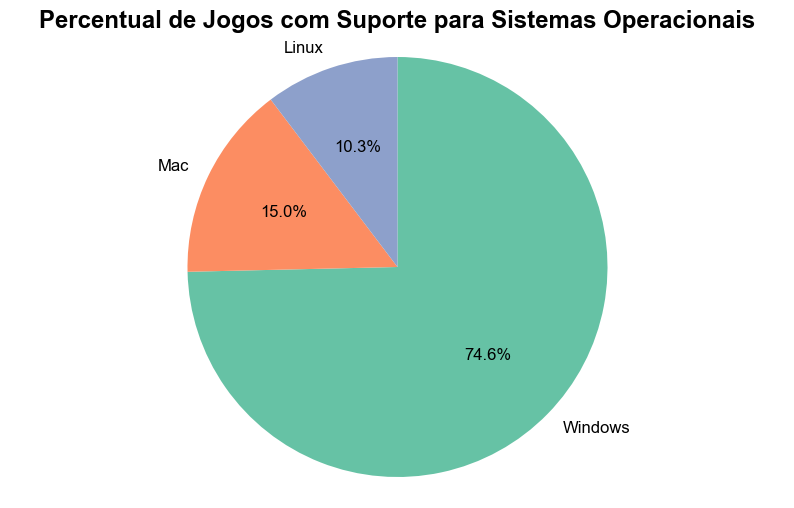

In [778]:
graphs.os_support_pie_chart()

>Gráfico 2: Número total de jogos single-player do gênero Indie e estratégia lançados por ano entre 2010 e 2020 (mostrar tendência para cada gênero separadamente, mas no mesmo gráfico).  



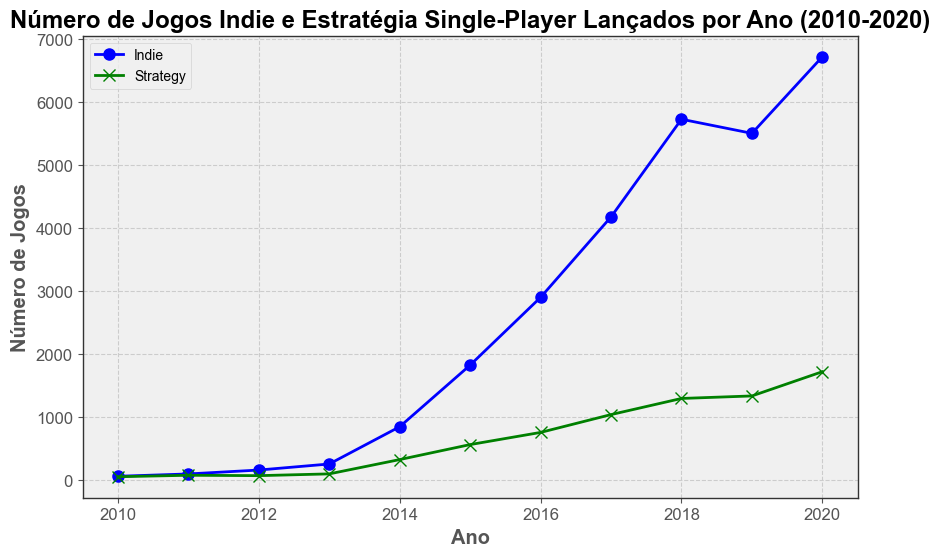

In [779]:
graphs.indie_strategy_trend()

>Gráfico do aluno: Percentual de jogos lançados por ano.

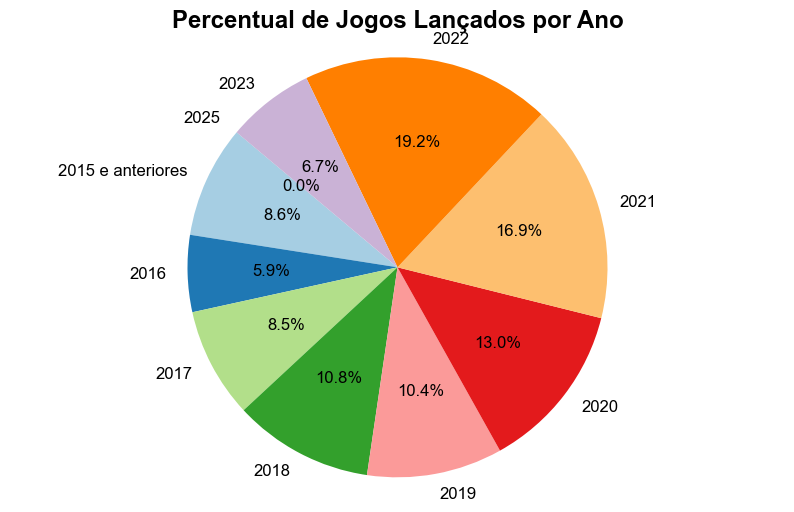

In [780]:
graphs.jogos_lancados_por_ano_pizza()